# Plots for mixture vMF

Loads pre-computed results from https://doi.org/10.57760/sciencedb.30181 and plots results used in the paper

In [1]:
import os
import geosss as gs

import numpy as np
from geosss.io import load
from arviz import autocorr
import seaborn as sns
import matplotlib.pyplot as plt
from geosss.sphere import distance
import pandas as pd
import logging
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

#### Set the used parameters and load the data sampled with GeoSSS, RWMH and HMC.

In [2]:
# set the parameters
d = 10  # dimension
K = 5  # number of mixture components
kappa = 100.0  # concentration parameter
reprod_switch = True  # generates reproducible results
plot_results = True  # plotting results
save_results = True  # saving results
n_samples = int(1e6)  # no. of samples
n_chains = 1  # sampler runs (ess only for `n_chains=10`)
burnin = int(0.1 * n_samples)  # burnin samples


# sampler methods
METHODS = ("sss-reject", "sss-shrink", "rwmh", "hmc", "mix-rwmh-indep")
ALGOS = {
    "sss-reject": "geoSSS (reject)",
    "sss-shrink": "geoSSS (shrink)",
    "rwmh": "RWMH",
    "hmc": "HMC",
    "mix-rwmh-indep": "mixture-MH",
}

# set filepaths and filenames
PATH = f"results/mix_vMF_d{d}_K{K}"
filename = f"mixture_vMF_d{d}_K{K}_kappa{int(kappa)}"
subdir = os.path.join(PATH, filename)

pklfile_samples = f"{subdir}/{filename}.pkl.gz"
pklfile_logprob = f"{subdir}/{filename}_logprob.pkl.gz"

# load samples and logprob
try:
    print(f"Loading file {pklfile_samples}")
    runs_samples = load(pklfile_samples, gzip=True)
except FileNotFoundError:
    raise FileNotFoundError(
        f"File {pklfile_samples} not found. Please run the sampler first."
    )

Loading file results/mix_vMF_d10_K5/mixture_vMF_d10_K5_kappa100/mixture_vMF_d10_K5_kappa100.pkl.gz


In [3]:
# Loading the first run `ind=0` to generate plots in paper
run_ind = 0
samples = runs_samples if isinstance(runs_samples, dict) else runs_samples[run_ind]

# fixes modes to fix the target
mode_seed = 1234
modes = gs.sphere.sample_sphere(d - 1, K, seed=mode_seed)

# target pdf as a mixture of von Mises-Fisher distributions
vmfs = [gs.VonMisesFisher(kappa * mu) for mu in modes]
pdf = gs.MixtureModel(vmfs)

#### Loading the samples from the mixture proposal Metropolis sampler

$K_{\text{mix}}(x, \cdot) = \alpha K_{\text{RWMH}}(x, \cdot) + (1 - \alpha) K_{\text{Indep.}}(x, \cdot)$

where $K_{\text{RWMH}}$ is the RWMH proposal and $K_{\text{Indep.}}$ Independence proposal and $\alpha \in (0, 1)$ is the mixing probability which is a hyperparameter that must be tuned for optimal result.

In [4]:
# loading the samples and its stats for varying alpha (mix_prob) and the first chain
mix_probs = np.arange(0.1, 1.1, 0.1)
samples_mix = {}
stats_mix = {}
run_ind = 1
for mix_prob in mix_probs:
    filename_mix = (
        f"sampler_mixture_rwmh_indep_kappa{kappa}_mixprob_{mix_prob:.1f}.pkl.gz"
    )
    loadfile = f"{subdir}/sampler_mixture_rwmh_indep/{filename_mix}"
    file = load(loadfile, gzip=True)
    samples_mix[f"prob_mix_{mix_prob:.1f}"] = file[f"run_{run_ind}"]["samples"]
    stats_mix[f"prob_mix_{mix_prob:.1f}"] = file[f"run_{run_ind}"]["stats"]

In [5]:
def compute_kld(samples, modes):
    """computing KL divergence between target and sampled distribution"""
    m = np.argmax(samples @ modes.T, axis=1)
    i, c = np.unique(m, return_counts=True)
    p = np.full(len(modes), 1e-100)
    p[i] = c
    p[i] /= p.sum()
    kld = p @ np.log(p / pdf.weights)
    return kld


# choose the best mixing probability based on KL divergence value (lowest)
kld_mix = []
for mix_prob in mix_probs:
    kld = compute_kld(samples_mix[f"prob_mix_{mix_prob:.1f}"], modes * kappa)
    print(f"mix_prob: {mix_prob:.1f}, KL divergence: {kld:.4f}")
    kld_mix.append(kld)

best_mix_prob = mix_probs[np.argmin(kld_mix)]
print(f"\nBest mixing probability: {best_mix_prob:.1f}")

mix_prob: 0.1, KL divergence: 0.0448
mix_prob: 0.2, KL divergence: 0.0124
mix_prob: 0.3, KL divergence: 0.0756
mix_prob: 0.4, KL divergence: 0.0398
mix_prob: 0.5, KL divergence: 0.0453
mix_prob: 0.6, KL divergence: 0.0458
mix_prob: 0.7, KL divergence: 0.0932
mix_prob: 0.8, KL divergence: 0.2830
mix_prob: 0.9, KL divergence: 0.6698
mix_prob: 1.0, KL divergence: 1.6094

Best mixing probability: 0.2


In [6]:
# updating the `samples` dict corresponding to the best mixing probability
samples["mix-rwmh-indep"] = samples_mix[f"prob_mix_{best_mix_prob:.1f}"]

In [7]:
# population of modes
# modes = np.array([p.mu for p in pdf.pdfs])

# kl-divergence
KL = []
for method in METHODS:
    x = samples[method]
    kld = compute_kld(x, modes * kappa)
    KL.append(kld)

# Calculate geodesic distances
geo_dist_list = []
for method in METHODS:
    x = samples[method]
    # Compute geodesic distances between successive samples
    geo_dist = distance(x[:-1], x[1:])
    # Check for Inf or NaN values
    if not np.all(np.isfinite(geo_dist)):
        logging.warning(f"Infinite or NaN values found in geo_dist for method {method}")
        # Remove or handle these values
        geo_dist = geo_dist[np.isfinite(geo_dist)]
        logging.info(
            "average great circle distance of successive samples: "
            f"{np.mean(geo_dist):.2f} ({method})"
        )
    # Create a DataFrame for the current method
    df_method = pd.DataFrame({"geo_dist": geo_dist, "method": method})
    geo_dist_list.append(df_method)

# Combine all DataFrames into one
df_geo_dist = pd.concat(geo_dist_list, ignore_index=True)

Saving ACF-KLD-geodesic distance plot..


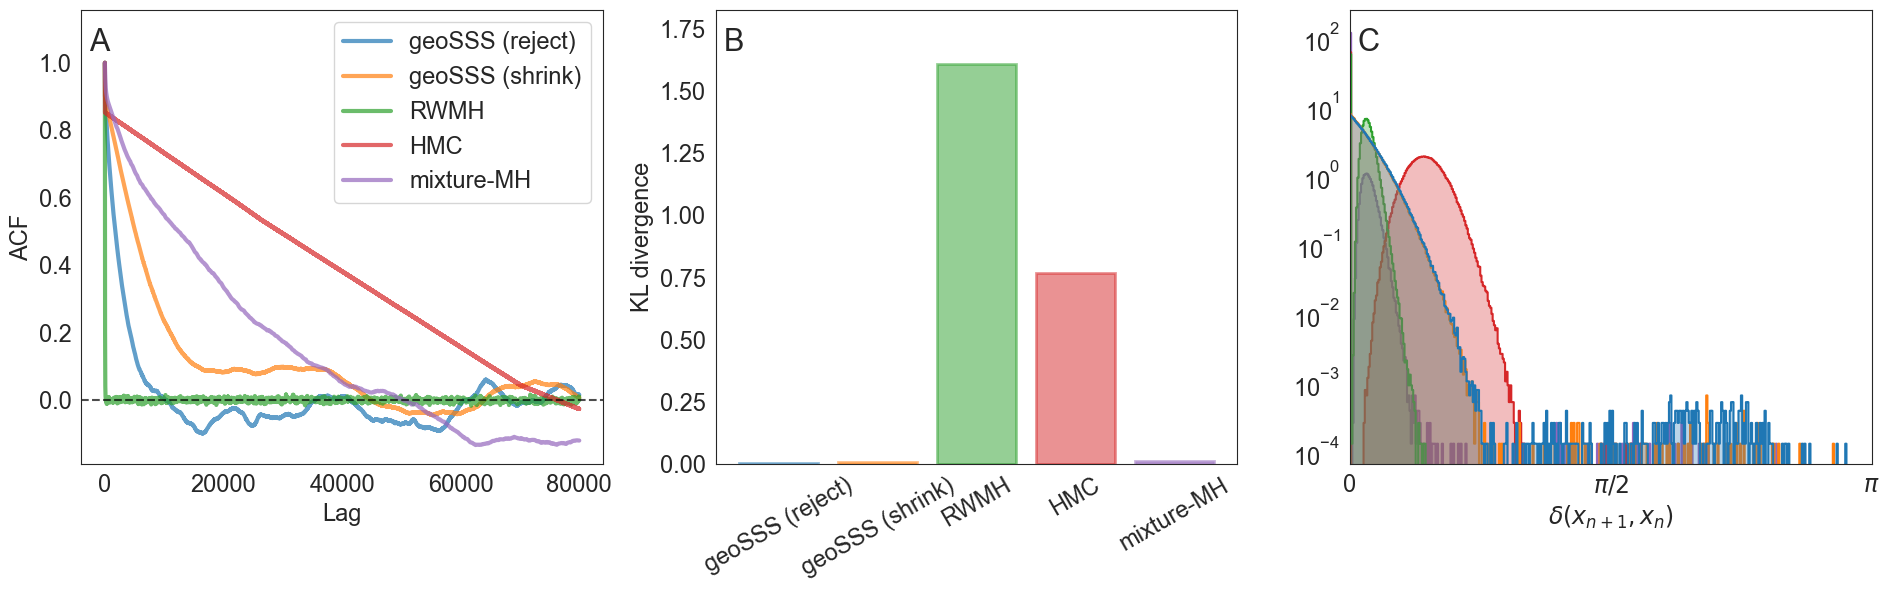

In [ ]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
method_color_dict = dict(zip(METHODS, colors))
fs = 17

lag = int(8e4)
fig, axes = plt.subplots(1, 3, figsize=(19, 6))
ax1 = axes[0]
for method, color in zip(METHODS, colors):
    # compute autocorrelation for every method
    ac = autocorr(samples[method][:, 0])[:lag]
    ax1.plot(
        ac,
        alpha=0.7,
        lw=3,
        label=ALGOS[method],
        color=color,
    )
ax1.axhline(0.0, ls="--", color="k", alpha=0.7)
ax1.set_xlabel(r"Lag", fontsize=fs)
ax1.set_ylabel("ACF", fontsize=fs)
ax1.legend(fontsize=fs, loc="upper right")
ax1.tick_params(axis="both", which="major", labelsize=fs)


# KL divergence
ax2 = axes[1]
ax2.set_ylabel("KL divergence", fontsize=fs)
ax2.bar(
    list(map(ALGOS.get, METHODS)),
    KL,
    color=colors,
    alpha=0.5,
    edgecolor=colors,
    linewidth=2,
)
ax2.tick_params(axis="x", labelrotation=30)
ax2.tick_params(axis="both", labelsize=fs)

ax3 = axes[2]

# Set the style
sns.set_style("white")  # Remove the background grid

# Create the histogram plot using Seaborn
sns.histplot(
    data=df_geo_dist,
    x="geo_dist",
    hue="method",
    bins=400,
    stat="density",
    element="step",  # Use 'bars' for filled histograms
    fill=True,  # Set to True for filled histograms
    common_norm=False,  # Normalize each histogram independently
    linewidth=1.5,  # Adjust line width for better visibility
    alpha=0.3,
    ax=ax3,
    palette=method_color_dict,
    legend=False,  # no legend ax3
)

# Customize the x-axis labels and ticks
ax3.set_xlabel(r"$\delta(x_{n+1}, x_n)$", fontsize=fs)
ax3.set_xticks([0, np.pi / 2, np.pi])
ax3.set_xticklabels(["0", r"$\pi/2$", r"$\pi$"], fontsize=fs)
ax3.tick_params(axis="both", which="major", labelsize=fs)

# Set y-scale to logarithmic
ax3.set_yscale("log")
ax3.set_ylabel(None)  # Remove the y-axis label
ax3.set_xlim(0, np.pi)

# annotate every subplot
for i, ax in enumerate(axes, 65):
    ax.annotate(chr(i), xy=(0.015, 0.91), xycoords="axes fraction", fontsize=22)

    # adding some margin on top
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + 0.08 * (ymax - ymin))

# Adjust layout
fig.tight_layout()

save_acf_kld_dist = True
if save_acf_kld_dist:
    print("Saving ACF-KLD-geodesic distance plot..")
    fig.savefig(f"{subdir}/{filename}_acf_kld_dist.pdf", transparent=True)

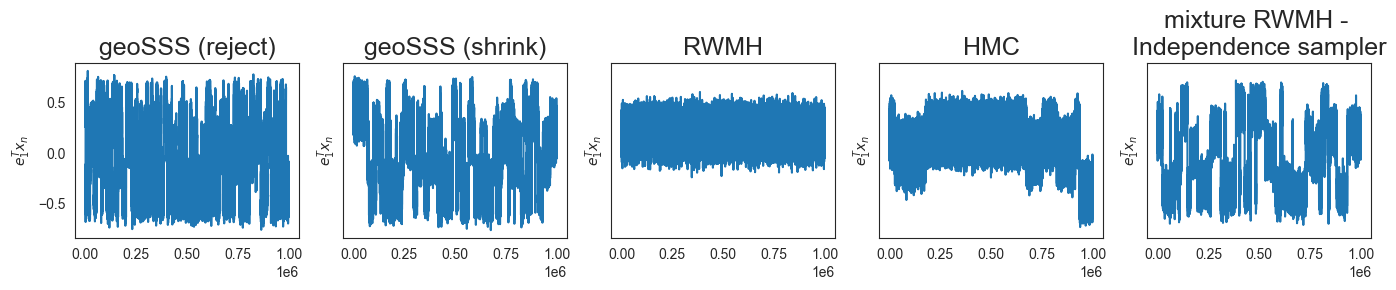

In [ ]:
# ac = autocorr(samples["hmc"][:, 0])[:lag]

fig, axes = plt.subplots(1, len(METHODS), figsize=(14, 3), sharey=True)
for ax, method in zip(axes, METHODS):
    ax.plot(samples[method][:, 7])
    ax.set_title(ALGOS[method], fontsize=fs + 1)
    ax.set_ylabel(r"$e_1^T x_n$")
fig.tight_layout()

Saving histogram plot with mixture marginals..


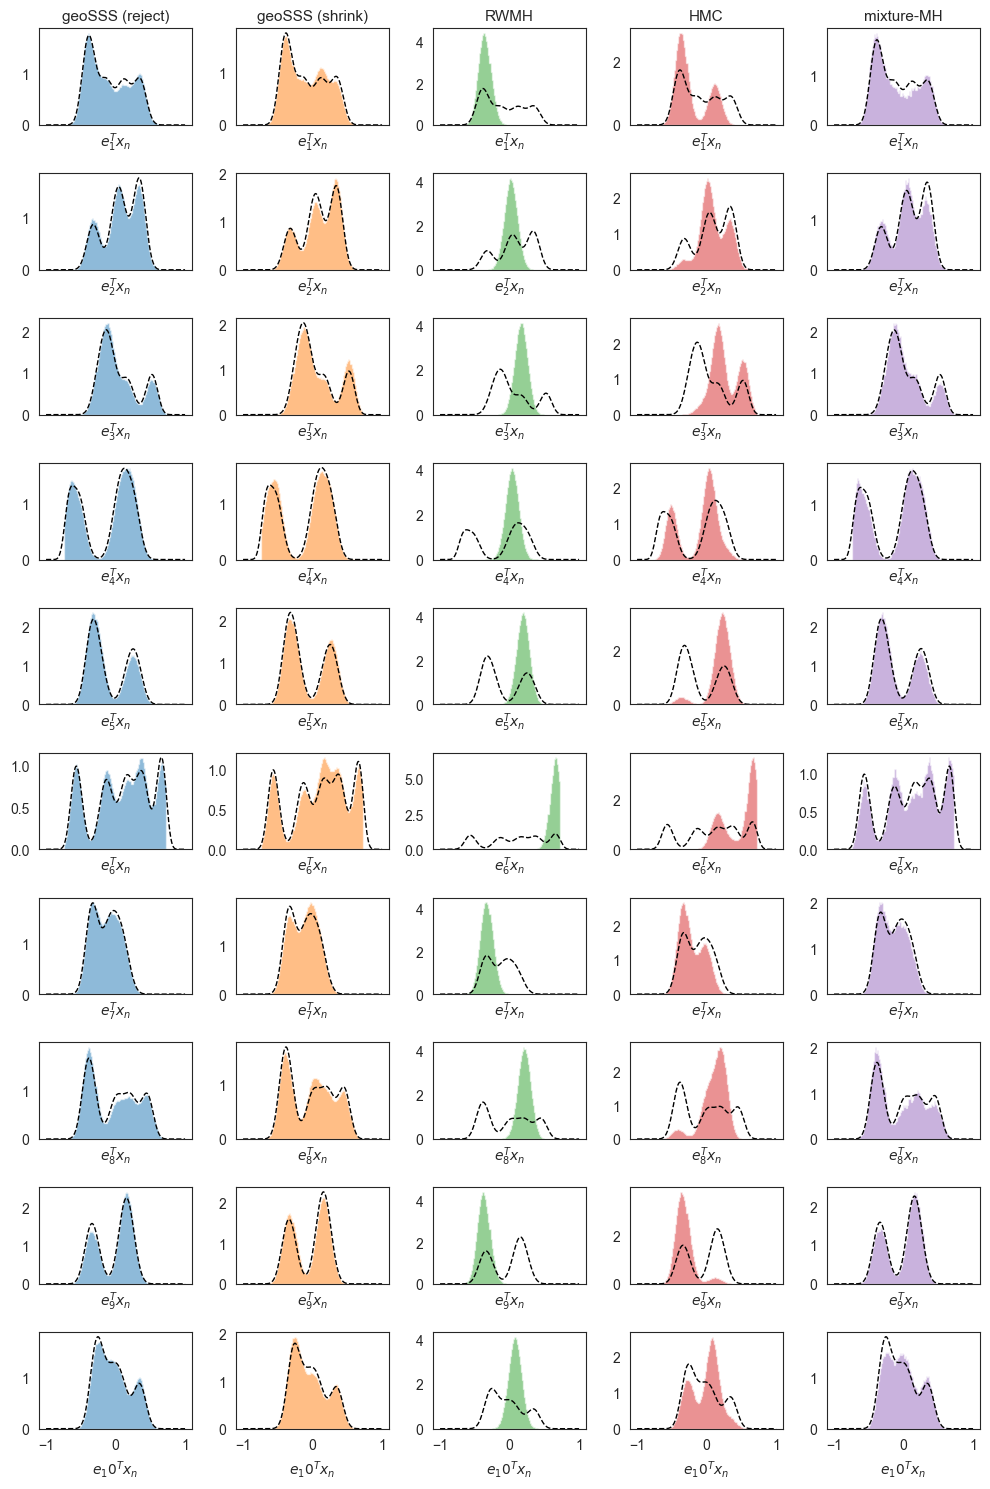

In [ ]:
from geosss.distributions import MarginalVonMisesFisher, VonMisesFisher, MixtureModel


def hist_plot_mixture_marginals(
    pdf, samples, ndim, path, filename, fs=16, save_res=False
):
    """
    histogram of samples.
    """
    bins = 100
    plt.rc("font", size=fs)

    # shows a standard histogram per dimension
    if ndim == 3:
        figsize = (10, 10)
    else:
        figsize = (10, 15)
    fig, rows = plt.subplots(ndim, len(METHODS), figsize=figsize, sharex=True)

    if isinstance(pdf, MixtureModel):
        mus = np.array([pdf.pdfs[i].mu for i in range(len(pdf.pdfs))])
    elif isinstance(pdf, VonMisesFisher):
        mus = pdf.mu

    # reference samples
    t = np.linspace(-1.0, 1.0, 1000)

    for d_idx, axes in enumerate(rows):
        # mixture of the marginals of von Mises-Fisher as ground truth samples
        marginalvMFs = [MarginalVonMisesFisher(d_idx, mu) for mu in mus]
        mixture_marginalvMFs = MixtureModel(marginalvMFs)
        log_p = mixture_marginalvMFs.log_prob(t)
        prob_truth = np.exp(log_p)

        # show histogram
        for ax, method in zip(axes, METHODS):
            marginals = samples[method][:, d_idx]
            bins = ax.hist(
                marginals,
                bins=bins,
                density=True,
                alpha=0.5,
                color=colors[METHODS.index(method)],
                histtype="stepfilled",
            )[1]
            ax.plot(t, prob_truth, ls="--", c="k", lw=1)
            label_val = d_idx + 1
            ax.set_xlabel(rf"$e_{label_val}^Tx_n$", fontsize=fs)

    for ax, method in zip(rows[0], METHODS):
        ax.set_title(ALGOS[method], fontsize=fs + 1)
    fig.tight_layout()

    if save_res:
        print("Saving histogram plot with mixture marginals..")
        fig.savefig(f"{path}/{filename}_hist_marginals.pdf", transparent=True)


hist_plot_mixture_marginals(
    pdf,
    samples,
    d,
    subdir,
    filename,
    fs=10,
    save_res=True,
)


In [ ]:
# just diagnosing how many samples correspond to each mode
for method in METHODS:
    x = samples[method]
    m = np.argmax(x @ modes.T, axis=1)
    i, c = np.unique(m, return_counts=True)
    print(f"{method}: ", c)

sss-reject:  [183185 196027 173365 221080 226343]
sss-shrink:  [181891 184255 253442 173708 206704]
rwmh:  [1000000]
hmc:  [614421 320830  64749]
mix-rwmh-indep:  [215711 171206 154827 228449 229807]
